# Финальная работа по модулю "Метрики, гипотезы, точки роста"

### Задание:
- Исследуем датасет на предмет качества, достаточности данных.  
- Формулируем предположения о бизнес-задаче, которую можно решить с помощью предложенных данных, заказчиках/пользователях отчета, их ожиданиях, системе метрик на основании датасета.  
- Проводим анализ данных.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 13,6

### Создание датафрейма для анализа

In [3]:
df = pd.read_csv('Data_Sample_AIC_Online_Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
1,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/10 8:34,1.69,13047.0,United Kingdom
2,536367,21755,LOVE BUILDING BLOCK WORD,3,12/1/10 8:34,5.95,13047.0,United Kingdom
3,536368,22914,BLUE COAT RACK PARIS FASHION,3,12/1/10 8:34,4.95,13047.0,United Kingdom
4,536373,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 9:02,2.75,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    54214 non-null  object 
 1   StockCode    54214 non-null  object 
 2   Description  54080 non-null  object 
 3   Quantity     54214 non-null  int64  
 4   InvoiceDate  54214 non-null  object 
 5   UnitPrice    54214 non-null  float64
 6   CustomerID   40643 non-null  float64
 7   Country      54214 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.3+ MB


In [5]:
# исправим типы данных
df['CustomerID'] = df['CustomerID'].astype('Int64')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    54214 non-null  object        
 1   StockCode    54214 non-null  object        
 2   Description  54080 non-null  object        
 3   Quantity     54214 non-null  int64         
 4   InvoiceDate  54214 non-null  datetime64[ns]
 5   UnitPrice    54214 non-null  float64       
 6   CustomerID   40643 non-null  Int64         
 7   Country      54214 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 3.4+ MB


**В колонках Description и CustomerID имеются пропуски, но удалять или заполнять их не имеет смысла, т.к. Description не особенно повлияет на результаты, а CustomerID заполнить на этапе анализа не возможно.**

### Добавим колонку с выручкой

In [7]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
1,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08
2,536367,21755,LOVE BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047,United Kingdom,17.85
3,536368,22914,BLUE COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047,United Kingdom,14.85
4,536373,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 09:02:00,2.75,17850,United Kingdom,22.00


### Посмотрим, корректны ли данные по количеству и цене, для этого выясним, есть ли выбросы

In [8]:
df_info = df[['Quantity', 'UnitPrice']]
df_info.describe()

,Quantity,UnitPrice
count,54214.000000,54214.000000
mean,9.610802,4.307341
std,57.358422,47.834496
min,-9600.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,2400.000000,6930.000000


**В данных определенно есть странные значения, их необходимо изучить**

In [9]:
df[df['Quantity'] < 0].sort_values('Quantity').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
22627,556691,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,<NA>,United Kingdom,-0.00
39137,C570556,20971,PINK BLUE FELT CRAFT TRINKET BOX,-1296,2011-10-11 11:10:00,1.06,16029,United Kingdom,-1373.76
43091,573598,79342B,"Unsaleable, destroyed.",-1128,2011-10-31 15:18:00,0.00,<NA>,United Kingdom,-0.00
43090,573597,79341,"Unsaleable, destroyed.",-905,2011-10-31 15:18:00,0.00,<NA>,United Kingdom,-0.00
35026,C567527,23113,PANTRY CHOPPING BOARD,-756,2011-09-21 09:16:00,5.06,17450,United Kingdom,-3825.36


**Видим, что если отсутствует покупатель и нулевая цена, то это скорее всего ликвидация товара или корректировки**

In [10]:
df[(df['CustomerID'].isna()) & (df['UnitPrice'] <= 0)].sort_values('Quantity').head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
22627,556691,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.0,<NA>,United Kingdom,-0.0
43091,573598,79342B,"Unsaleable, destroyed.",-1128,2011-10-31 15:18:00,0.0,<NA>,United Kingdom,-0.0
43090,573597,79341,"Unsaleable, destroyed.",-905,2011-10-31 15:18:00,0.0,<NA>,United Kingdom,-0.0
2129,538090,20956,?,-723,2010-12-09 14:48:00,0.0,<NA>,United Kingdom,-0.0
34093,566712,22030,??,-635,2011-09-14 12:04:00,0.0,<NA>,United Kingdom,-0.0
11573,546018,85172,wrongly sold as sets,-600,2011-03-08 17:23:00,0.0,<NA>,United Kingdom,-0.0
13309,547559,72759,thrown away-can't sell.,-524,2011-03-23 17:27:00,0.0,<NA>,United Kingdom,-0.0
37426,569341,82600,historic computer difference?....se,-458,2011-10-03 14:19:00,0.0,<NA>,United Kingdom,-0.0
20136,554143,79030G,damages,-413,2011-05-23 10:40:00,0.0,<NA>,United Kingdom,-0.0
28248,561639,84799,NaN,-346,2011-07-28 14:58:00,0.0,<NA>,United Kingdom,-0.0


### Удалим из датафрейма эти строки для возможности проведения анализа в разрезе ассортимента

In [11]:
df_negative = df[(df['CustomerID'].isna()) & (df['UnitPrice'] <= 0)]

In [12]:
df_new = df.drop(df_negative.index, axis = 0)

In [13]:
df_new.sort_values('Quantity').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
39137,C570556,20971,PINK BLUE FELT CRAFT TRINKET BOX,-1296,2011-10-11 11:10:00,1.06,16029,United Kingdom,-1373.76
35026,C567527,23113,PANTRY CHOPPING BOARD,-756,2011-09-21 09:16:00,5.06,17450,United Kingdom,-3825.36
7757,C542693,15036,ASSORTED COLOURS SILK FAN,-600,2011-01-31 12:36:00,0.65,12908,United Kingdom,-390.00
39136,C570556,22149,FELTCRAFT 6 FLOWER FRIENDS,-600,2011-10-11 11:10:00,1.85,16029,United Kingdom,-1110.00
41463,C572343,22103,MIRROR MOSAIC T-LIGHT HOLDER ROUND,-468,2011-10-24 10:40:00,0.39,14607,United Kingdom,-182.52


### Теперь изучим ситуацию с ценами

In [14]:
df_new.sort_values('UnitPrice', ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
17425,C551699,M,Manual,-1,2011-05-03 14:12:00,6930.00,16029,United Kingdom,-6930.00
31245,C564341,AMAZONFEE,AMAZON FEE,-1,2011-08-24 14:53:00,6662.51,<NA>,United Kingdom,-6662.51
12122,C546557,M,Manual,-1,2011-03-15 09:44:00,2583.76,<NA>,Hong Kong,-2583.76
42864,C573550,AMAZONFEE,AMAZON FEE,-1,2011-10-31 13:32:00,2185.04,<NA>,United Kingdom,-2185.04
11832,546329,M,Manual,1,2011-03-11 10:22:00,1687.17,14911,EIRE,1687.17


**На этапе анализа трудно установить, что подразумевается под кодом Manual, поэтому оставим это как есть, а AMAZON FEE видимо является расходами, которые нужно убрать.**

In [15]:
df_new.drop(df_new[df_new.StockCode == 'AMAZONFEE'].index, inplace=True)

In [16]:
df_new.sort_values('UnitPrice', ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
17425,C551699,M,Manual,-1,2011-05-03 14:12:00,6930.00,16029,United Kingdom,-6930.00
12122,C546557,M,Manual,-1,2011-03-15 09:44:00,2583.76,<NA>,Hong Kong,-2583.76
11832,546329,M,Manual,1,2011-03-11 10:22:00,1687.17,14911,EIRE,1687.17
50859,579196,DOT,DOTCOM POSTAGE,1,2011-11-28 15:54:00,1526.76,14096,United Kingdom,1526.76
48504,577531,DOT,DOTCOM POSTAGE,1,2011-11-20 13:58:00,1236.75,<NA>,United Kingdom,1236.75


**Всего сумма выручки составляет 1008943.44 $**

In [17]:
round(df_new['Revenue'].sum(),2)

1008943.44

**В данных есть корректировочные инвойсы на общую сумму -47224.55 $**

In [18]:
df_new[(df_new['InvoiceNo'].str.startswith('C'))]['Revenue'].sum()

-47224.55

In [19]:
round(df_new[(df_new['InvoiceNo'].str.startswith('C'))]['Revenue'].sum()/df_new['Revenue'].sum() * -100,2)

4.68

**Что составляет 4,68% - не значимая сумма, поэтому корректировочные инвойсы можно удалить, чтобы не анализировать отрицательные количества позиций.**

In [20]:
df_neg = df_new[(df_new['InvoiceNo'].str.startswith('C'))]

In [21]:
df_new = df_new.drop(df_neg.index, axis = 0)

**Уберем оставшиеся позиции с нулевыми ценами**

In [22]:
df_new.drop(df_new[df_new.UnitPrice == 0].index, inplace=True)

In [23]:
df_info = df_new[['Quantity', 'UnitPrice']]
df_info.describe()

,Quantity,UnitPrice
count,53029.000000,53029.000000
mean,10.421147,3.835168
std,37.629879,17.814690
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,11.000000,4.130000
max,2400.000000,1687.170000


**Проверим количество дней продаж в месяцах в представленном датасете**

In [24]:
df_date_day = df_new.groupby([pd.Grouper(key="InvoiceDate", freq="D")])['Revenue'].sum().reset_index()
df_date_day['InvoiceMonth'] = df_date_day['InvoiceDate'].apply(lambda x: x.strftime('%B-%Y'))
df_date_day = df_date_day.groupby('InvoiceMonth')['InvoiceDate'].count().reset_index()
df_date_day.style.bar(align='mid')

,InvoiceMonth,InvoiceDate
0,April-2011,30
1,August-2011,31
2,December-2010,31
3,December-2011,9
4,February-2011,28
5,January-2011,31
6,July-2011,31
7,June-2011,30
8,March-2011,31
9,May-2011,31


**Очевидно, что в декабре 2011 г. к анализу представлено только 9 дней, поэтому логично будет исключить их из датасета**

In [25]:
df_new.drop(df_new[df_new.InvoiceDate >= '2011-11-30 23:59:59'].index, inplace=True)

In [26]:
df_new.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
51674,579885,23137,ZINC WIRE SWEETHEART LETTER TRAY,1,2011-11-30 17:37:00,3.75,15444,United Kingdom,3.75
51675,579885,22186,RED STAR CARD HOLDER,2,2011-11-30 17:37:00,1.95,15444,United Kingdom,3.90
51676,579885,23406,HOME SWEET HOME KEY HOLDER,1,2011-11-30 17:37:00,6.25,15444,United Kingdom,6.25
51677,579885,23452,HEART MINI PORTRAIT FRAME,4,2011-11-30 17:37:00,1.95,15444,United Kingdom,7.80
51678,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444,United Kingdom,12.48


### Теперь данные готовы к анализу

**В целом на основании этих данные можно принимать некоторые решения, способствующие увеличению выручки и заказов, а также удержанию активных клиентов.**

**Финансовому директору будет интересна выручка по месяцам, а генеральному директору также наиболее пользующиеся спросом товары и страны  с наибольшей выручкой.**

**Cлужбе маркетинга будут интересны**
 - **наиболее активные покупатели по сумме и количеству инвойсов**
 - **средняя сумма инвойса**  
**Эти метрики позволят сделать вывод о необходимости и типе акций для покупателей и поощрению особо активных, а также о стимулировании продаж в определенные периоды на основании динамики средней суммы инвойса**

In [27]:
sns.set_theme(style="darkgrid")

In [28]:
df_date_inv = df_new.groupby([pd.Grouper(key="InvoiceDate", freq="M"), 'InvoiceNo'])['Revenue'].sum().reset_index()
df_date_inv_ = df_date_inv.groupby("InvoiceDate").agg({'Revenue':'sum', 'InvoiceNo':'count'}).reset_index()
df_date_inv_['Average revenue per invoice'] = round(df_date_inv_['Revenue']/df_date_inv_['InvoiceNo'], 2)
df_date_inv_.style.bar(align='mid')

,InvoiceDate,Revenue,InvoiceNo,Average revenue per invoice
0,2010-12-31 00:00:00,79513.230000,1024,77.650000
1,2011-01-31 00:00:00,66024.230000,776,85.080000
2,2011-02-28 00:00:00,50651.980000,769,65.870000
3,2011-03-31 00:00:00,77141.400000,1015,76.000000
4,2011-04-30 00:00:00,51989.050000,867,59.960000
5,2011-05-31 00:00:00,77554.720000,1128,68.750000
6,2011-06-30 00:00:00,77615.360000,1051,73.850000
7,2011-07-31 00:00:00,76444.330000,1021,74.870000
8,2011-08-31 00:00:00,77937.610000,938,83.090000
9,2011-09-30 00:00:00,101598.511000,1349,75.310000


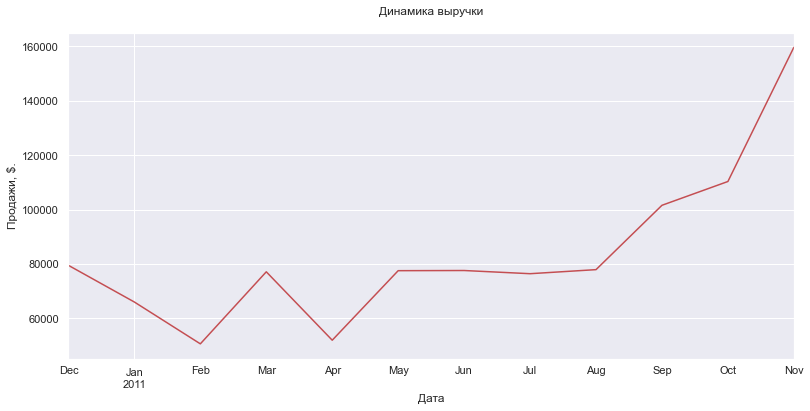

In [29]:
df_date_inv_r = df_date_inv_.set_index('InvoiceDate')
df_date_inv_r['Revenue'].plot(title='Динамика выручки\n', color='r',
                             xlabel='Дата', 
                             ylabel='Продажи, $.');

**Из графика видно, что выручка более-менее равномерна за исключением резкого роста в период с сентября по ноябрь и падения в декабре. Самые неудачные месяцы - февраль, апрель и декабрь 2010.**

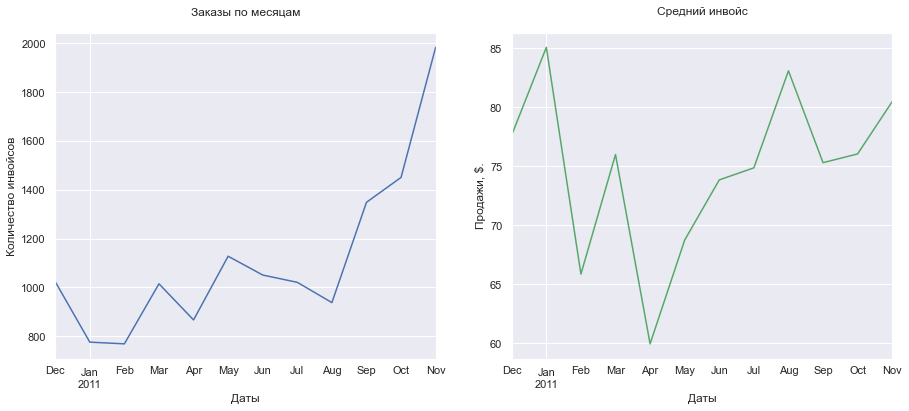

In [30]:
plt.figure(1, figsize=(15,6))
plt.subplot(121)
df_date_inv_r['InvoiceNo'].plot(title='Заказы по месяцам\n', 
                             xlabel='Даты', 
                             ylabel='Количество инвойсов')
plt.subplot(122)
df_date_inv_r['Average revenue per invoice'].plot(color='g',
                            title='Средний инвойс\n', 
                             xlabel='Даты', 
                             ylabel='Продажи, $.');

**График, отражающий количество заказов по месяцам приблизительно совпадает с графиком выручки, тогда как средний инвойс имеет наиболее высокие значения в августе, ноябре, декабре 2010 и январе, а самые неудачные месяцы по прежнему февраль и апрель.  
По всем трем графикам можно сделать вывод что в феврале и апреле необходимо предпринимать активные меры по стимулированию продаж как по количеству заказов так и по ассортименту, а в январе какие-нибудь широкомасштабные акции по прилечению новых покупателей.**

In [31]:
df_users = df_new.groupby(['CustomerID', 'InvoiceNo'])['Revenue'].sum().reset_index()
df_users_ = df_users.groupby(['CustomerID']).agg({'InvoiceNo':'count', 'Revenue':'sum'}).reset_index()
df_users_inv = df_users_.sort_values('InvoiceNo', ascending=False).head(10).set_index('CustomerID')

In [32]:
df_users_cust = df_users_.sort_values('Revenue', ascending=False).head(10).set_index('CustomerID')

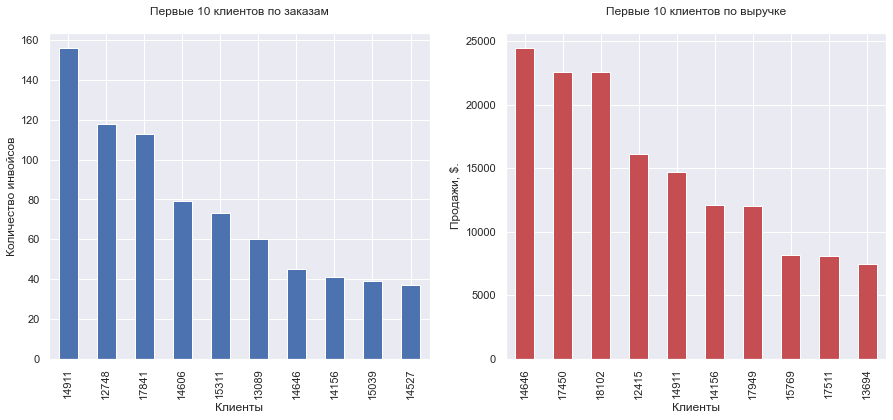

In [33]:
plt.figure(1, figsize=(15,6))
plt.subplot(121)
df_users_inv['InvoiceNo'].plot(kind='bar', title='Первые 10 клиентов по заказам\n', 
                             xlabel='Клиенты', 
                             ylabel='Количество инвойсов')
plt.subplot(122)
df_users_cust['Revenue'].plot(kind='bar', color='r',
                            title='Первые 10 клиентов по выручке\n', 
                             xlabel='Клиенты', 
                             ylabel='Продажи, $.');

In [34]:
print(f"Коды самых прекрасных клиентов {list(df_users_inv.merge(df_users_cust, how='inner', on='CustomerID').reset_index()['CustomerID'])}")

Коды самых прекрасных клиентов [14911, 14646, 14156]


**На графиках показаны лучшие клиенты по выручке и количеству заказов, для их удержания возможно нужно провести какие-то акции.**

In [35]:
df_new_st = df_new.groupby(['StockCode', 'Description']).agg({'Quantity':'count', 'Revenue':'sum'}).reset_index()
df_new_st.sort_values('Quantity', ascending=False).head(10)

,StockCode,Description,Quantity,Revenue
3085,85123A,WHITE HANGING HEART T-LIGHT HOLDER,224,9492.14
3069,85099B,JUMBO BAG RED RETROSPOT,213,9901.00
1225,22423,REGENCY CAKESTAND 3 TIER,174,16380.32
145,20725,LUNCH BAG RED RETROSPOT,161,3616.66
387,21212,PACK OF 72 RETROSPOT CAKE CASES,156,3332.93
2530,47566,PARTY BUNTING,152,7237.83
147,20727,LUNCH BAG BLACK SKULL.,142,2188.74
1193,22386,JUMBO BAG PINK POLKADOT,139,5794.93
1212,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,135,3206.04
1510,22720,SET OF 3 CAKE TINS PANTRY DESIGN,134,3668.32


In [36]:
df_new_st.sort_values('Revenue', ascending=False).head(10)

,StockCode,Description,Quantity,Revenue
3396,DOT,DOTCOM POSTAGE,76,20607.25
1225,22423,REGENCY CAKESTAND 3 TIER,174,16380.32
3069,85099B,JUMBO BAG RED RETROSPOT,213,9901.00
3085,85123A,WHITE HANGING HEART T-LIGHT HOLDER,224,9492.14
2530,47566,PARTY BUNTING,152,7237.83
3398,POST,POSTAGE,98,6958.16
2908,84879,ASSORTED COLOUR BIRD ORNAMENT,133,6691.98
1193,22386,JUMBO BAG PINK POLKADOT,139,5794.93
3397,M,Manual,30,5601.25
2662,79321,CHILLI LIGHTS,58,5453.61


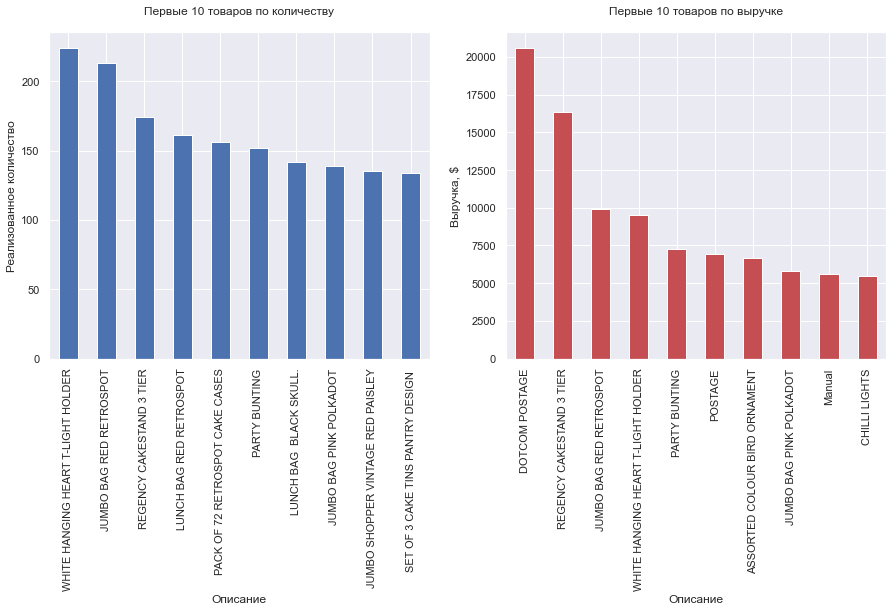

In [37]:
plt.figure(1, figsize=(15,6))
plt.subplot(121)
df_new_st_ = df_new_st.sort_values('Quantity', ascending=False).head(10).set_index('Description')
df_new_st_['Quantity'].plot(kind='bar', title='Первые 10 товаров по количеству\n',
                             xlabel='Описание', 
                             ylabel='Реализованное количество')
plt.subplot(122)
df_new_st_r = df_new_st.sort_values('Revenue', ascending=False).head(10).set_index('Description')
df_new_st_r['Revenue'].plot(kind='bar', title='Первые 10 товаров по выручке\n', color='r',
                             xlabel='Описание', 
                             ylabel='Выручка, $');

**Из графиков видно, что половина товаров в обеих группах совпадают и возможно в части ассортимента нужно двигаться в этом направлении**

In [38]:
print('Лучшие товары:\n')
for x in list(df_new_st_.merge(df_new_st_r, how='inner', on='Description').reset_index()['Description']):
    print(x)

Лучшие товары:

WHITE HANGING HEART T-LIGHT HOLDER
JUMBO BAG RED RETROSPOT
REGENCY CAKESTAND 3 TIER
PARTY BUNTING
JUMBO BAG PINK POLKADOT


In [39]:
df_new_con = df_new.groupby(['Country', 'InvoiceNo']).agg({'Revenue':'sum'}).reset_index()
df_new_con_=df_new_con.groupby(['Country']).agg({'InvoiceNo':'count', 'Revenue':'sum'}).reset_index()
df_new_con_.sort_values('Revenue', ascending=False).head(10)

,Country,InvoiceNo,Revenue
35,United Kingdom,11997,846641.761
10,EIRE,219,28449.090
24,Netherlands,60,25419.260
14,Germany,311,22688.390
13,France,286,19405.580
0,Australia,32,17156.590
32,Switzerland,39,6215.900
30,Spain,68,5927.110
31,Sweden,21,4936.520
3,Belgium,77,3876.960


In [40]:
df_new_con_.sort_values('InvoiceNo', ascending=False).head(10)

,Country,InvoiceNo,Revenue
35,United Kingdom,11997,846641.761
14,Germany,311,22688.390
13,France,286,19405.580
10,EIRE,219,28449.090
3,Belgium,77,3876.960
30,Spain,68,5927.110
24,Netherlands,60,25419.260
27,Portugal,42,3722.600
32,Switzerland,39,6215.900
0,Australia,32,17156.590


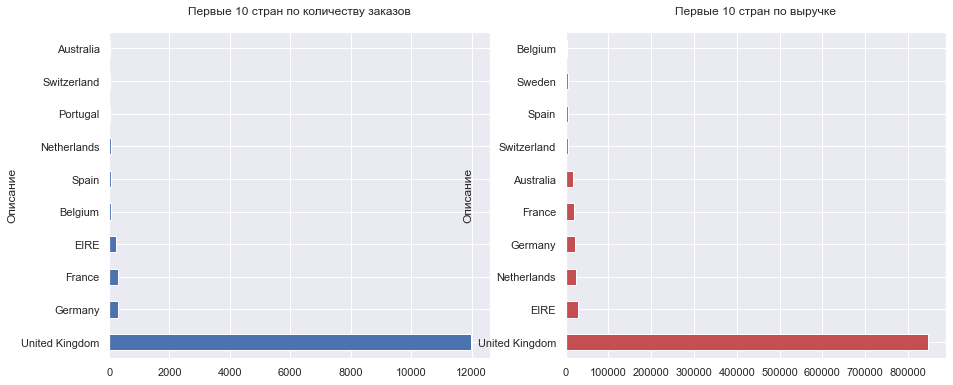

In [41]:
plt.figure(1, figsize=(15,6))
plt.subplot(121)
df_new_con_c = df_new_con_.sort_values('InvoiceNo', ascending=False).head(10).set_index('Country')
df_new_con_c['InvoiceNo'].plot(kind='barh', title='Первые 10 стран по количеству заказов\n',
                             xlabel='Описание', 
                             ylabel='Количество заказов')
plt.subplot(122)
df_new_con_r = df_new_con_.sort_values('Revenue', ascending=False).head(10).set_index('Country')
df_new_con_r['Revenue'].plot(kind='barh', title='Первые 10 стран по выручке\n', color='r',
                             xlabel='Описание', 
                             ylabel='Выручка, $');

**Наибольшая доля выручки и заказов приходится на Великобританию, но далее данные расходятся - в Ирландии и Нидерландах  предпочитают делать меньше заказов и приобретать более дорогие товары, тогда как в Германии и Франции заказывают больше, но менее дорогие позиции.**

In [42]:
country_des_rev = df_new[(df_new['Country'].isin(list(df_new_con_r.index))) & (df_new['Description'].isin(list(df_new_st_r.index)))].pivot_table(
                        index='Country', 
                        columns='Description', 
                        values='Revenue', 
                        aggfunc=sum).fillna(0)
country_des_rev

Description,ASSORTED COLOUR BIRD ORNAMENT,CHILLI LIGHTS,DOTCOM POSTAGE,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,Manual,PARTY BUNTING,POSTAGE,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
Country,,,,,,,,,,
Australia,0.00,0.00,0.00,0.00,179.00,0.00,0.00,0.00,350.40,0.00
Belgium,0.00,0.00,0.00,0.00,19.50,0.00,19.80,423.00,38.25,0.00
EIRE,67.60,23.00,0.00,0.00,92.82,1687.17,39.60,0.00,414.15,624.30
France,0.00,0.00,0.00,61.10,80.60,0.00,102.45,1513.00,452.40,0.00
Germany,67.60,0.00,0.00,149.24,162.50,549.34,0.00,2112.00,204.00,0.00
Netherlands,0.00,0.00,0.00,0.00,853.00,0.00,0.00,90.00,350.40,0.00
Spain,0.00,23.00,0.00,20.80,20.80,0.00,0.00,420.00,538.35,0.00
Sweden,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,0.00,0.00
Switzerland,0.00,0.00,0.00,0.00,122.20,0.00,0.00,520.00,226.20,11.80


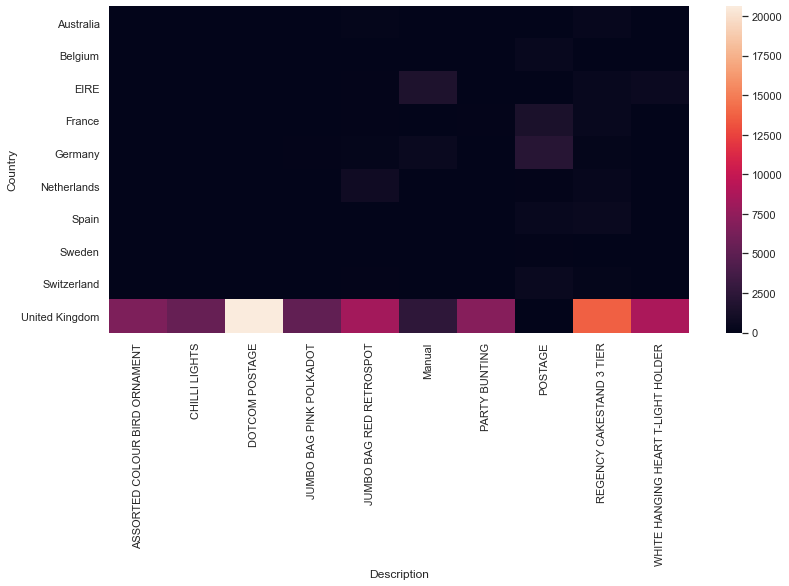

In [43]:
sns.heatmap(country_des_rev);

**В таком варианте тепловой карты можно оценить только продажи по топ 10 товарам в Великобритании, т.к. сумма выручки по другим странам в разрезе товаров намного меньше чем в Великобритании**

In [44]:
top_countries = list(df_new_con_r.index)
top_countries.remove('United Kingdom')

In [45]:
country_des_rev = df_new[(df_new['Country'].isin(top_countries)) & (df_new['Description'].isin(list(df_new_st_r.index)))].pivot_table(
                        index='Country', 
                        columns='Description', 
                        values='Revenue', 
                        aggfunc=sum).fillna(0)

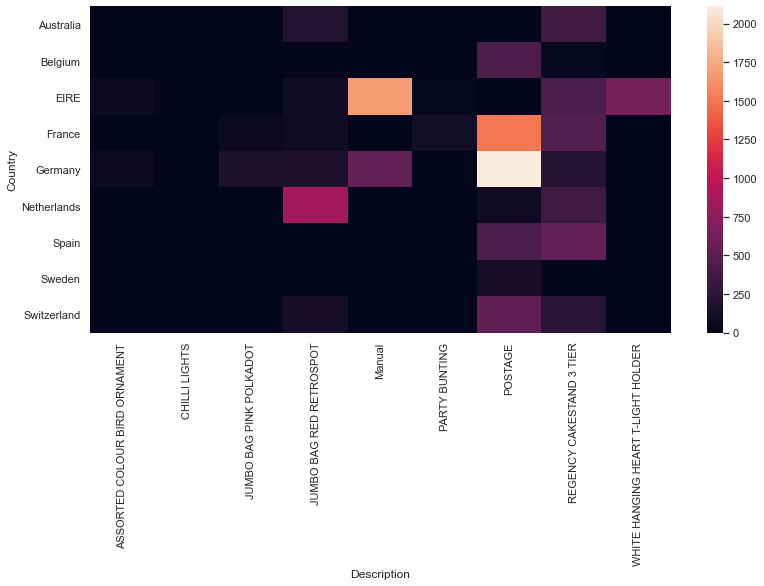

In [46]:
sns.heatmap(country_des_rev);

**На этой тепловой карте уже можно оценить предпочтения жителей разных стран в отношении топ 10 товаров, например ирландцам нравятся подвесные держатели, а в Нидерландах любят красные спортивные сумки, и если бы база данных заполнялась более тщательно, то было бы известно, что скрывается за POSTAGE и Manual.** 

In [47]:
df_new.to_excel("df_new_AIC.xlsx")